In [6]:
import glob
from transformers import BertTokenizerFast, BertModel
from pprint import pprint
from belt_nlp.splitting import transform_single_text
import torch
import numpy as np
from tqdm import tqdm, tqdm_gui
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [18]:
def process_text(text_path, tokenizer, embedder, get_embeddings=False):
    with open(text_path, 'r') as text_file:
        text = text_file.read()

    labels_path = text_path.replace('.txt', '-labels-subtask-3.txt').replace('-articles-subtask-3', '-labels-subtask-3-spans')
    with open(labels_path, 'r') as labels_file:
        labels = labels_file.read()
        labels = [l.split('\t') for l in labels.split('\n')][:-1]
    
    res = dict()

    res['edges'] = [(int(l[2]), int(l[3])) for l in labels]

    tokens = tokenizer(text, add_special_tokens=False, truncation=False, return_tensors='pt',
                       return_offsets_mapping=True)
    res['tokens'] = tokens
    res['num_tokens'] = len(tokens['input_ids'][0])
    input_ids, attention_mask = transform_single_text(
        text,
        tokenizer,
        chunk_size=510,
        stride=300,
        minimal_chunk_length=20,
        maximal_text_length=None
    )
    res['chunks'] = input_ids
    res['attn_mask'] = attention_mask

    res['tokens']['offset_mapping'] = res['tokens']['offset_mapping'].squeeze()
    res['span_tokens_edges_ids'] = []
    for i in range(len(res['edges'])):
        start, end = res['edges'][i]
        for j in range(len(res['tokens']['offset_mapping'])):
            if res['tokens']['offset_mapping'][j][0] == start:
                start = j
            if res['tokens']['offset_mapping'][j][1] == end:
                end = j
                break
        res['span_tokens_edges_ids'].append((start, end))
    assert len(res['edges']) == len(res['span_tokens_edges_ids'])

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    embedder.to(device)
    embeddings = []
    for i in range(len(res['chunks'])):
        with torch.no_grad():
            output = embedder(res['chunks'][i].unsqueeze(0).to(device),
                              res['attn_mask'][i].unsqueeze(0).to(device))
        _start = 0 if i == 0 else 210
        _end = list(res['attn_mask'][i]).index(0) if 0 in res['attn_mask'][i] else 0
        last_hidden_state = output.last_hidden_state[:, 1+_start:-1+_end, :].detach().cpu()
        embeddings.append(last_hidden_state)
    embeddings = torch.cat(embeddings, dim=1)

    # SPANS
    spans = [text[int(l[2]):int(l[3])] for l in labels]
    res['spans'] = spans

    # NONE CLASS
    # space_ids = [i for i in range(len(text)) if ' ' == text[i]]
    # span_edges = [(int(l[2]), int(l[3])) for l in labels]
    # def overlap(s, e, edgs):
    #     return any([not (e < edgs[i][0] or s > edgs[i][1]) for i in range(len(edgs))])
    
    # none_classes, none_spans = [], []
    # for i in range(len(spans)):
    #     _len = len(spans[i].split())
    #     start = space_ids.index(np.random.choice(space_ids))
    #     end = start + _len
    #     counter = 1
    #     while overlap(start, end, span_edges) and counter < 200:
    #         start = space_ids.index(np.random.choice(space_ids))
    #         end = start + _len
    #         counter += 1
    #     none_spans.append(' '.join(text.split()[start:end + 1]))
    #     none_classes.append('NoClass')

    # res['spans'].extend(none_spans)

    # # SPAN EMDEDDINGS
    # span_tokens = [
    #     tokenizer(span, add_special_tokens=False, truncation=False)
    #     for span in res['spans']
    # ]
    # span_embeddings = []
    # res['classes'] = []
    # for j in range(len(span_tokens)):
    #     try:
    #         for i in range(len(tokens['input_ids'][0])):
    #             if (tokens['input_ids'][0][i:i + len(span_tokens[j]['input_ids'])].numpy() == span_tokens[j]['input_ids']).all():
    #                 span_embeddings.append(embeddings[:, i:i + len(span_tokens[j]['input_ids']), :])
    #                 try:
    #                     res['classes'].append(labels[j][1])
    #                 except IndexError as e:
    #                     pass
    #                 break
    #     except ValueError as e:
    #         print(text_path, labels_path)
    # res['span_embeddings'] = span_embeddings

    # res['classes'].extend(none_classes)

    text = text.lower()
    for l in labels:
        text = text.replace(text[int(l[2]):int(l[3])], text[int(l[2]):int(l[3])].upper())
    res['text'] = text

    return res, embeddings

In [67]:
tokenizer = BertTokenizerFast.from_pretrained('SpanBERT/spanbert-base-cased')
embedder = BertModel.from_pretrained('SpanBERT/spanbert-base-cased', add_pooling_layer=False)

path = np.random.choice(glob.glob('./dataset/data/en/dev-articles-subtask-3/*.txt'))
r, _ = process_text(path, tokenizer, embedder)
# pprint(r['span_tokens_edges_ids'])
# pprint(r['tokens']['offset_mapping'])
pprint(r)

{'attn_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0,

In [62]:
class CustomDeepClassifier(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=2048):
        super(CustomDeepClassifier, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(1))

        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(1))

        layers.append(nn.Linear(hidden_dim, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = F.sigmoid(x)
        return x

model = CustomDeepClassifier()
model.load_state_dict(torch.load('binary_model_diff-sum.pt'))
model.eval()

CustomDeepClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1536, out_features=2048, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [72]:
tokenizer = BertTokenizerFast.from_pretrained('SpanBERT/spanbert-base-cased')
embedder = BertModel.from_pretrained('SpanBERT/spanbert-base-cased', add_pooling_layer=False)

path = np.random.choice(glob.glob('./dataset/data/en/dev-articles-subtask-3/*.txt'))
r, embs = process_text(path, tokenizer, embedder)
embs.shape

torch.Size([1, 1204, 768])

In [78]:
max_span_len = 120
res = dict()

for span_len in range(1, max_span_len):
    res[span_len] = []
    for start_id in range(embs.shape[1] - span_len):
        raw_embedding = embs[:, start_id:start_id + span_len, :]
        embedding = torch.cat(
            (
                raw_embedding[:, 0, :] + raw_embedding[:, -1, :],
                raw_embedding[:, 0, :] - raw_embedding[:, -1, :]
            ),
            dim=1
        )
        # print(embedding.shape)
        output = model(embedding.unsqueeze(0))
        res[span_len].append(output.detach().cpu().numpy()[0][0][0])
    res[span_len].extend([0] * span_len)
    res[span_len] = np.array(res[span_len])

[(222, 242), (239, 242), (245, 270), (497, 508), (612, 614), (661, 669), (695, 696), (713, 715), (854, 858), (876, 895)]


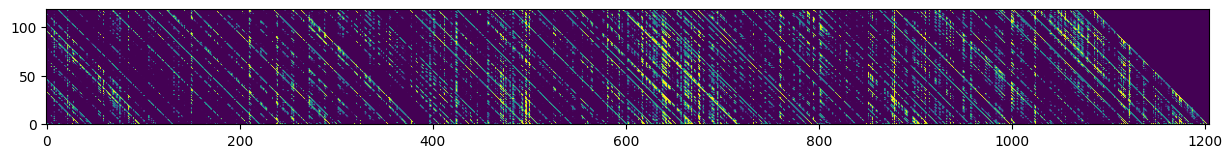

In [79]:
heatmap = [res[key] for key in list(res.keys())]

fig = plt.figure(figsize=(15, 15))

print(r['span_tokens_edges_ids'])

plt.imshow(heatmap)
plt.gca().invert_yaxis()
plt.show()